# Cosine Similarity with Transcriptions

Notebook used to find cosine similarity between video transcriptions and NYT articles

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import re

2024-03-30 13:38:50.512501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
""" # get combined pdf to access dates

cwd = os.getcwd()
metadata_dir = f'{cwd}/../pre-processing/metadata-csv'
metadata_files = [file for file in os.listdir(metadata_dir) if "Sec2Gr3_" in file]      # only get metadata files for our group

dataframes = []

for file in metadata_files:
    file_path = os.path.join(metadata_dir, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.head() """

' # get combined pdf to access dates\n\ncwd = os.getcwd()\nmetadata_dir = f\'{cwd}/../pre-processing/metadata-csv\'\nmetadata_files = [file for file in os.listdir(metadata_dir) if "Sec2Gr3_" in file]      # only get metadata files for our group\n\ndataframes = []\n\nfor file in metadata_files:\n    file_path = os.path.join(metadata_dir, file)\n    df = pd.read_csv(file_path)\n    dataframes.append(df)\n\ncombined_df = pd.concat(dataframes, ignore_index=True)\ncombined_df.head() '

In [34]:
cwd = os.getcwd()
transcript_dir = f'{cwd}/../transcription/'
transcript_df = pd.read_csv(os.path.join(transcript_dir, 'final_transcriptions.csv'))

""" transcripts = [file for file in os.listdir(transcript_dir) if file.endswith('.txt')]

transcript_dict = {'video_id': [], 'transcription': []}

for file in transcripts:
    video_id = file.split('.')[0]
    with open(os.path.join(transcript_dir, file), "r") as transcription_file:
        transcription = transcription_file.read()

    transcript_dict['video_id'].append(video_id)
    transcript_dict['transcription'].append(transcription)

transcript_df = pd.DataFrame(transcript_dict) """

' transcripts = [file for file in os.listdir(transcript_dir) if file.endswith(\'.txt\')]\n\ntranscript_dict = {\'video_id\': [], \'transcription\': []}\n\nfor file in transcripts:\n    video_id = file.split(\'.\')[0]\n    with open(os.path.join(transcript_dir, file), "r") as transcription_file:\n        transcription = transcription_file.read()\n\n    transcript_dict[\'video_id\'].append(video_id)\n    transcript_dict[\'transcription\'].append(transcription)\n\ntranscript_df = pd.DataFrame(transcript_dict) '

In [35]:
transcript_df.head()

,video_id,Transcription,Date,Length,Original Comparison
0,7297432141485444394,The Zionist argument we will address today is...,2023-11-03,51,hashtag
1,7298819910145232174,"I think I didn't see you, there were flashing...",2023-11-07,41,nyt
2,7294328136831962398,I wanna be where the fuck my blunt where the ...,2023-10-26,27,nyt
3,7306664718050102570,So it has come to my attention and to a lot o...,2023-11-28,70,nyt
4,7298818526658235694,"I think I didn't see you, there were flashing...",2023-11-07,62,nyt


In [36]:
""" date_df = combined_df[['video_id', 'video_timestamp']]
date_df['video_date'] = date_df['video_timestamp'].str[:10] """

" date_df = combined_df[['video_id', 'video_timestamp']]\ndate_df['video_date'] = date_df['video_timestamp'].str[:10] "

In [37]:
# date_df = date_df.set_index('video_id')
# transcript_df = transcript_df.set_index('video_id')

In [38]:
""" date_df.loc[:, 'video_id'] """

" date_df.loc[:, 'video_id'] "

In [39]:
""" date_df['video_id'] = date_df.loc[:, 'video_id'].astype(str) """
transcript_df['video_id'] = transcript_df['video_id'].astype(str)

In [40]:
""" transcript_date_df = pd.merge(transcript_df, date_df, on='video_id') """
transcript_df.head()

,video_id,Transcription,Date,Length,Original Comparison
0,7297432141485444394,The Zionist argument we will address today is...,2023-11-03,51,hashtag
1,7298819910145232174,"I think I didn't see you, there were flashing...",2023-11-07,41,nyt
2,7294328136831962398,I wanna be where the fuck my blunt where the ...,2023-10-26,27,nyt
3,7306664718050102570,So it has come to my attention and to a lot o...,2023-11-28,70,nyt
4,7298818526658235694,"I think I didn't see you, there were flashing...",2023-11-07,62,nyt


In [41]:
print(transcript_df.shape)

(227, 5)


In [42]:
# load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [43]:
# cosine similarity function, from week 7 notebook
from numpy.linalg import norm

def cosineSimilarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    V1 = np.array(vec1)
    V2 = np.array(vec2)
    cosine = np.dot(V1, V2)/(norm(V1)*norm(V2))
    return cosine

In [13]:
from get_nyt_articles_revised import filter_by_date, filter_by_week

In [44]:
def cosine_sim_nyt(nyt_df, col_name, trans_embedding):
    max_similarity = -1  # initialize maximums
    max_index = -1
    for index, nyt_row in nyt_df.iterrows():
        cosine_similarities = {}
        try:
            nyt_embedding = embed([nyt_row[col_name]])[0]               # universal sentence encoder
            
            # calculate cosine similarity
            cosine_sim = cosineSimilarity(trans_embedding, nyt_embedding)

            if cosine_sim > max_similarity:
                max_similarity = cosine_sim
                max_index = index
                top_row = nyt_df.loc[max_index]
        except:
            cosine_sim = -999        
    headline = top_row['headline']

    print(f"Index of Maximum Cosine Similarity for {col_name}:", max_index)
    print(f"Maximum Cosine Similarity for {col_name}:", max_similarity)

    return (max_similarity, headline, col_name)


""" Cell In[16], line 19
     16     except:
     17         cosine_sim = -999
---> 19     headline = top_row['headline']
     21 print(f"Index of Maximum Cosine Similarity for {col_name}:", max_index)
     22 print(f"Maximum Cosine Similarity for {col_name}:", max_similarity)

UnboundLocalError: cannot access local variable 'top_row' where it is not associated with a value """

' Cell In[16], line 19\n     16     except:\n     17         cosine_sim = -999\n---> 19     headline = top_row[\'headline\']\n     21 print(f"Index of Maximum Cosine Similarity for {col_name}:", max_index)\n     22 print(f"Maximum Cosine Similarity for {col_name}:", max_similarity)\n\nUnboundLocalError: cannot access local variable \'top_row\' where it is not associated with a value '

In [45]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

In [46]:
def clean_transcription(transcript):
    """
    Helper function, takes video transcript and splits into words, removes punctuation, and stop words
    """
    if pd.isna(transcript):  
        return [] 
    
    # remove numbers from the text
    transcript = re.sub(r'\d+', '', transcript)

    # split the description into words
    words = transcript.split()
    
    # make everything lowercase
    cleaned_words = [word.lower() for word in words]
    
    # remove stop words
    cleaned_words = [word for word in cleaned_words if word not in stop_words]

    # remove empty strings
    cleaned_words = [word for word in cleaned_words if word]

    sentence = " ".join(cleaned_words)
    
    return sentence

In [47]:
def split_keywords(text):
    """Split text into individual keywords based on whitespace and punctuation, remove stop words"""
    if pd.isna(text):  # check if text is NaN
        return []  
    
    # split text into individual keywords based on whitespace and punctuation
    keywords = re.findall(r'\b\w+\b', text)

    # remove stop words
    cleaned_words = [word.lower() for word in keywords if word not in stop_words]
    
    return cleaned_words

def clean_headline(text):
    """Split headline into individual words based on whitespace and punctuation, remove stop words"""
    if pd.isna(text):  # check if text is NaN
        return []  
    
    # remove numbers from the text
    text = re.sub(r'\d+', '', text)

    # split text into individual keywords based on whitespace
    keywords = text.split()

    # remove stop words
    cleaned_words = [word.lower() for word in keywords if word not in stop_words]
    
    return cleaned_words

In [57]:
transcript_df_sub = transcript_df[:5]

In [68]:
total_num_videos = len(transcript_df)
for index, row in transcript_df.iterrows():
    print(f"Processing video {index+1}/{total_num_videos}, video id: {row['video_id']}")

    print(row)
    print(index)
    
    transcript_embedding = embed([row['Transcription']])[0]              # universal sentence encoder
    nyt_df = filter_by_week(row['Date'])

    ## Part 1: transcription comparison to headline, abstract, lead_paragraph
    headline_comp = cosine_sim_nyt(nyt_df, 'headline', transcript_embedding)
    abstract_comp = cosine_sim_nyt(nyt_df, 'abstract', transcript_embedding)
    leadpara_comp = cosine_sim_nyt(nyt_df, 'lead_paragraph', transcript_embedding)

    transcript_df.loc[index, 'headline_sim'] = headline_comp[0]
    transcript_df.loc[index, 'abstract_sim'] = abstract_comp[0]
    transcript_df.loc[index, 'leadpara_sim'] = leadpara_comp[0]

    max = -1
    top_headline = 'xxx'
    type_comp = 'yyy'

    for cosine_sim, headline, col in [headline_comp, abstract_comp, leadpara_comp]:
        if cosine_sim > max:
            max = cosine_sim
            top_headline = headline
            type_comp = col

    transcript_df.loc[index,'top_cosine_sim'] = max
    transcript_df.loc[index,'top_headline'] = top_headline
    transcript_df.loc[index,'top_headline_fromtype'] = type_comp

    ## Part 2: transcription keyword comparison to NYT keywords (revised by us)
    nyt_df['keywords_cleaned'] = nyt_df['keywords'].apply(split_keywords)
    nyt_df['headline_cleaned'] = nyt_df['headline'].apply(clean_headline)
    nyt_df['nyt_keywords'] = nyt_df['keywords_cleaned'] + nyt_df['headline_cleaned']
    nyt_df['article_sentence'] = nyt_df.apply(lambda row: ' '.join(row['keywords_cleaned'] + row['headline_cleaned']), axis=1)
    
    transcription_key_sen = clean_transcription(row['Transcription'])
    trans_key_embedding = embed([transcription_key_sen])[0]

    # find cosine similarity for each article 
    max_sim_keywords = -1  # initialize maximums
    max_index_keywords = -1
    for index2, nyt_row in nyt_df.iterrows():
        cosine_similarities_kyewords = {}
        nyt_embedding = embed([nyt_row['article_sentence']])[0]               # universal sentence encoder
    
         # calculate cosine similarity
        cosine_sim_key = cosineSimilarity(trans_key_embedding, nyt_embedding)

        if cosine_sim_key > max_sim_keywords:
            max_sim_keywords = cosine_sim_key
            max_index_keywords = index2
            top_row_key = nyt_df.loc[max_index_keywords]
    headline_key = top_row_key['headline']
    
    print("Index of Maximum Cosine Similarity for Keywords:", max_index_keywords)
    print("Maximum Cosine Similarity for Keywords:", max_sim_keywords)

    transcript_df.loc[index,'top_cosine_sim_keywords'] = max_sim_keywords
    transcript_df.loc[index,'top_headline_keywords'] = headline_key
    transcript_df.loc[index,'transcript_keywords'] = transcription_key_sen
    transcript_df.loc[index,'top_nyt_article_keywords'] = top_row_key['article_sentence']

Processing video 1/227, video id: 7297432141485444394
video_id                                             7297432141485444394
Transcription           The Zionist argument we will address today is...
Date                                                          2023-11-03
Length                                                                51
Original Comparison                                              hashtag
Name: 0, dtype: object
0
NYT data for 2023-11-06 already in folder

NYT data for 2023-11-05 already in folder

NYT data for 2023-11-04 already in folder

NYT data for 2023-11-03 already in folder

NYT data for 2023-11-02 already in folder

NYT data for 2023-11-01 already in folder

NYT data for 2023-10-31 already in folder

Index of Maximum Cosine Similarity for headline: 469
Maximum Cosine Similarity for headline: 0.5929881
Index of Maximum Cosine Similarity for abstract: 469
Maximum Cosine Similarity for abstract: 0.58697295
Index of Maximum Cosine Similarity for lead_para

In [66]:
transcript_df_sub.head()

,video_id,Transcription,Date,Length,Original Comparison,headline_sim,abstract_sim,leadpara_sim,top_cosine_sim,top_headline,top_headline_fromtype,top_cosine_sim_keywords,top_headline_keywords,transcript_keywords,top_nyt_article_keywords
0,7297432141485444394,The Zionist argument we will address today is...,2023-11-03,51,hashtag,0.592988,0.586973,0.589289,0.592988,"Many are killed near a Gaza hospital, its chie...",headline,0.661423,"In High-Stakes Speech, Hezbollah’s Leader Stop...",zionist argument address today hamas terrorist...,hezbollah nasrallah hassan israel hamas palest...
1,7298819910145232174,"I think I didn't see you, there were flashing...",2023-11-07,41,nyt,0.230880,0.203958,0.341359,0.341359,A Knock at the Door,lead_paragraph,0.239260,Taking Note as Dance Reflections Takes a Pause,"think see you, flashing lights least decency k...",dancing la horde dance group vienne gisele cha...
2,7294328136831962398,I wanna be where the fuck my blunt where the ...,2023-10-26,27,nyt,0.266673,0.239590,0.258715,0.266673,What’s in Our Queue? ‘Talk to Me’ and More,headline,0.185573,How Hard Is It to Wake Up in the Morning?,wanna fuck blunt fuck figure talking inside i'...,how hard is it wake up morning?
3,7306664718050102570,So it has come to my attention and to a lot o...,2023-11-28,70,nyt,0.507899,0.284711,0.549142,0.549142,"Jung Kook, BTS and English Language K-Pop",lead_paragraph,0.540259,"Jung Kook, BTS and English Language K-Pop",come attention lot older k-pop stans' attentio...,audio neutral informative k pop bts music grou...
4,7298818526658235694,"I think I didn't see you, there were flashing...",2023-11-07,62,nyt,0.270368,0.226697,0.296230,0.296230,A Knock at the Door,lead_paragraph,0.265692,"Rice Krispie Treats in a Plastic Tube, and Oth...","think see you, flashing lights least decency k...",dancing chocolate factory the ellsworth michel...


In [69]:
transcript_df.head()

,video_id,Transcription,Date,Length,Original Comparison,headline_sim,abstract_sim,leadpara_sim,top_cosine_sim,top_headline,top_headline_fromtype,top_cosine_sim_keywords,top_headline_keywords,transcript_keywords,top_nyt_article_keywords
0,7297432141485444394,The Zionist argument we will address today is...,2023-11-03,51,hashtag,0.592988,0.586973,0.589289,0.592988,"Many are killed near a Gaza hospital, its chie...",headline,0.661423,"In High-Stakes Speech, Hezbollah’s Leader Stop...",zionist argument address today hamas terrorist...,hezbollah nasrallah hassan israel hamas palest...
1,7298819910145232174,"I think I didn't see you, there were flashing...",2023-11-07,41,nyt,0.230880,0.203958,0.341359,0.341359,A Knock at the Door,lead_paragraph,0.239260,Taking Note as Dance Reflections Takes a Pause,"think see you, flashing lights least decency k...",dancing la horde dance group vienne gisele cha...
2,7294328136831962398,I wanna be where the fuck my blunt where the ...,2023-10-26,27,nyt,0.266673,0.239590,0.258715,0.266673,What’s in Our Queue? ‘Talk to Me’ and More,headline,0.185573,How Hard Is It to Wake Up in the Morning?,wanna fuck blunt fuck figure talking inside i'...,how hard is it wake up morning?
3,7306664718050102570,So it has come to my attention and to a lot o...,2023-11-28,70,nyt,0.507899,0.284711,0.549142,0.549142,"Jung Kook, BTS and English Language K-Pop",lead_paragraph,0.540259,"Jung Kook, BTS and English Language K-Pop",come attention lot older k-pop stans' attentio...,audio neutral informative k pop bts music grou...
4,7298818526658235694,"I think I didn't see you, there were flashing...",2023-11-07,62,nyt,0.270368,0.226697,0.296230,0.296230,A Knock at the Door,lead_paragraph,0.265692,"Rice Krispie Treats in a Plastic Tube, and Oth...","think see you, flashing lights least decency k...",dancing chocolate factory the ellsworth michel...


In [70]:
transcript_df.to_csv('transcript_cosine_sim.csv')

### Histogram

In [10]:
import matplotlib.pyplot as plt

In [7]:
transcript_df2 = pd.read_csv('transcript_cosine_sim.csv', index_col=0)

In [30]:
category = ["headline_sim", "abstract_sim", "leadpara_sim", "top_cosine_sim_keywords"]
titles = ["Transcript vs NYT Headline", "Transcript vs NYT Abstract", "Transcript vs NYT Lead Paragraph", "Transcript Keywords vs NYT Keywords and Headline"]
bins=np.arange(0, 1, 0.02)

In [32]:
for cat in category:
    print(transcript_df2[f"{cat}"].median())

0.30419278
0.31916004
0.3534942
0.33249113


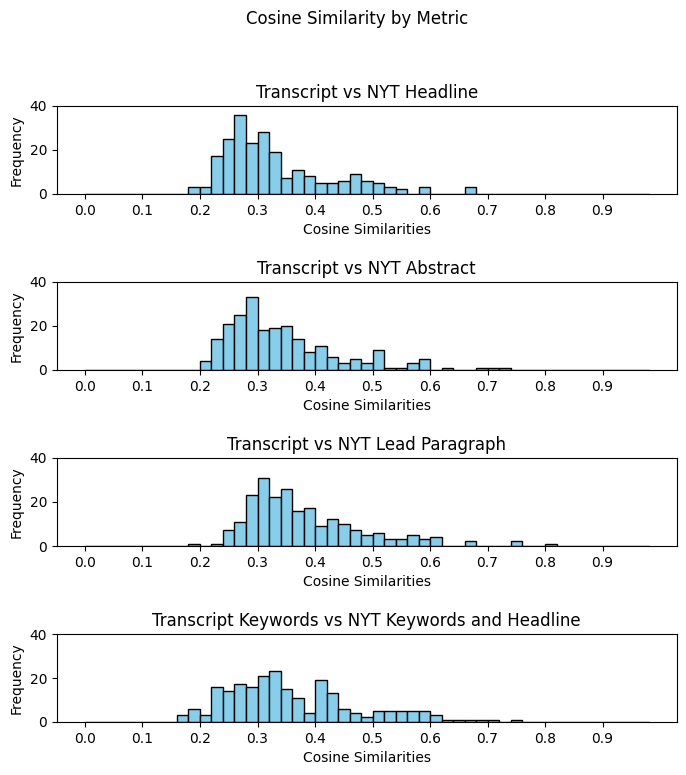

In [29]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=1.0)
plt.suptitle('Cosine Similarity by Metric', y=1.0)

for n, category in enumerate(category):
    ax = plt.subplot(4, 1,n+1)
    ax.hist(transcript_df2[f"{category}"], bins=bins, color='skyblue', edgecolor='black')
    ax.set_xticks(np.arange(0, 1, step=0.1))
    ax.set_title(titles[n])
    ax.set_ylim(0, 40)
    ax.set_xlabel('Cosine Similarities')
    ax.set_ylabel('Frequency')